# <span style="color:green"> Numerical Simulation Laboratory: Numerical Exercises 6 </span>
## Exercise 06.1
## <span style="color:firebrick"> Comment on the C++ code - Structure </span> 
The C++ code is based on the class **Ising** (ising.h, ising.cpp), which contains: 
1. **Data**.
    - One random generator;
    - The variables $\mathrm{Nspin, Nblocks, Nsteps, Nobs}$, which express respectively the number of spins, the number of blocks, the number of steps for each block (thus the total number of steps is just $\mathrm{Nblocks\times Nsteps}$) and the number of observables (since they are by default $U, C, M, \chi$, this is set equal to 4);
    - The array $\mathrm{Spin}$ that stores the values of each spin ($\pm 1$);
    - The arrays $\mathrm{ObsMean, ObsSigma}$ containing the progressive averages and standard deviations of each observables, computed with the blocking method;
    - The objects $\mathrm{U\_data, S\_data}$ (class **Stat**) which store all the measures of **total energy** and **total spin** of the system. They allow to carry on the statistical analysis by means of the blocking method.
  
  
2. **Methods**. Alongside the constructors, the set and get methods, we have the following methods:
    - $\mathrm{SetRandom}$, which initializes the configuration by setting each spin with a random value;
    - $\mathrm{LoadConfig}$ instead loads an old configuration from the file **config.final**, thus allowing to restart from the last configuration of an earlier simulation;
    - $\mathrm{Flip}$, which tries to flip each spin and accepts the modification by means of the **Metropolis** and **Gibbs** algorithms;
    - $\mathrm{AutoEquilibration}$, an automatic version of the equilibration process. It consists in a series of calls to $\mathrm{Flip}$ followed by a measure of the instantaneous value of $U$. This process stops when the maximum number of cycles (set by default to 2000) is reached, or <span style="color:green"> if the **standard deviation of $U$** gets below a suitable threshold</span>. This ensures that the system is in a neighbourhood of the equilibrium.
    - $\mathrm{Simulate}$, which calls $\mathrm{Nblocks\times Nsteps}$ the function $\mathrm{Flip}$ and appends the measure to the containers of the objects $\mathrm{U\_data, S\_data}$.

## <span style="color:firebrick"> Comment on the C++ code - Usage </span> 
The output folder is called **OutputData**. Here can be found the final values of the observables. However, the spin configuration files are located in the same folder as the executable program.<br>
The input file is **input.dat**, which allows to set all the parameters of the system for each configuration. The program allows to repeat any number of simulations without the need to restart it: indeed, **input.dat** can be modified while the program is running if a different simulation is to be performed. This file has the following structure:

||Physical   parameters|
|:-------:|:--------|
|50 		|		Number of spins|
|0.5:2.0:20	| Write just T for one simulation, or Tmin:Tmax:Steps ("Steps" cycles in the range $[Tmin, Tmax]$). |
|1.0 		|	$J$ |
|0.02  		|	$H_{ext}$|

|| Simulation parameters |
|:-------:|:--------|
|30 	|Number of blocks |
|1000 	| Number of steps [for each block]|
|m			|Algorithm Option ('m' or 'g')|

||  Input/Output  |
|:-------:|:--------|
|1	|Read the starting configuration from <config.final>|
|0 	|Output $U$|
|0	|Output $C$|
|1	|Output $M$|
|0	|Output $X$|

<span style="color:firebrick"> **IMPORTANT**: </span>
1. The spacing between the number and the text is irrelevant. However, they must be kept separated, in order to ensure a correct input process.
2. If the input values of $T$ are expressed in the form $Tmin:Tmax:Tcycles$, the program runs $Tcycles$ simulations using the values $T\in[Tmin, Tmax]$ distributed uniformly.
3. At the beginning of each simulation, the program asks if the output files shall be overwritten. This allows to use the "append" mode if one wants to simulate an arbitrary set of $T$ value and plot them in the same graph. However, for this exercise we used the procedure mentioned in point 2 (without needing to append any data to existing files). 

## <span style="color:firebrick"> Comment on the Python code - Usage </span> 
We first define the functions $U, C, M, \chi$ corresponding to the exact values of the observables for this system. We also introduce the function $Read$, which gets the output of the C++ program (it can be used with any output file contained in **OutputData**).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os.path

th, exp, ch, sh, sqrt = np.tanh, np.exp, np.cosh, np.sinh, np.sqrt

def U_f(N, T, J, Hext): # Hext = 0
    x = J/T
    return -J*(th(x) + th(x)**(N-1))/(1 + th(x)**N)

def C_f(N, T, J, Hext): # Hext = 0
    x = J/T
    d = 1+th(x)**N
    return (x**2)*((1 + th(x)**N + (N-1)*(th(x)**2) + (N-1)*(th(x)**(N-2)))/d - N*((th(x)+th(x)**(N-1))/d)**2)

def M_f(N, T, J, Hext):
    x = J/T
    y = Hext/T
    lambda1 = exp(x)*ch(y)+sqrt(exp(2*x)*(ch(y)**2)-2*sh(2*x))
    lambda2 = exp(x)*ch(y)-sqrt(exp(2*x)*(ch(y)**2)-2*sh(2*x))
    D = exp(x)*ch(y)/sqrt(exp(2*x)*ch(y)*ch(y)-2*sh(2*x))
    Z = lambda1**N + lambda2**N
    return exp(x)*sh(y) * ( (lambda1**(N-1))*(1+D) + (lambda2**(N-1))*(1-D) ) / (Z)

def X_f(N, T, J, Hext):
    x = J/T
    return 1/T*exp(2*x)*(1-th(x)**N)/(1+th(x)**N)

def Read(filename): # Generic Read function (Metropolis, Gibbs)
    Nspin, T, J, Hext, O_mean, O_sigma = [], [], [], [], [], []
    V = [T, J, Hext, O_mean, O_sigma]
    with open("Esercizio06.1/OutputData/"+filename) as file:
        for line in file:
            Nspin.append(int(line.split()[0]))
            for i in range(1, 6):
                V[i-1].append(float(line.split()[i]))
    return Nspin, T, J, Hext, O_mean, O_sigma

We now proceed with the representation of the results produced by the simulation. In particular, both the Gibbs and Metropolis algorithms prove to be in excellent agreement with the expected values of all the four observables (for this reason, some error bars cannot be seen with the actual configuration).
However, if $T<0.5$, we noticed that the estimate of the magnetic susceptibility $\chi$ becomes much more inaccurate, due to the divergence which occurs at $T=0$.

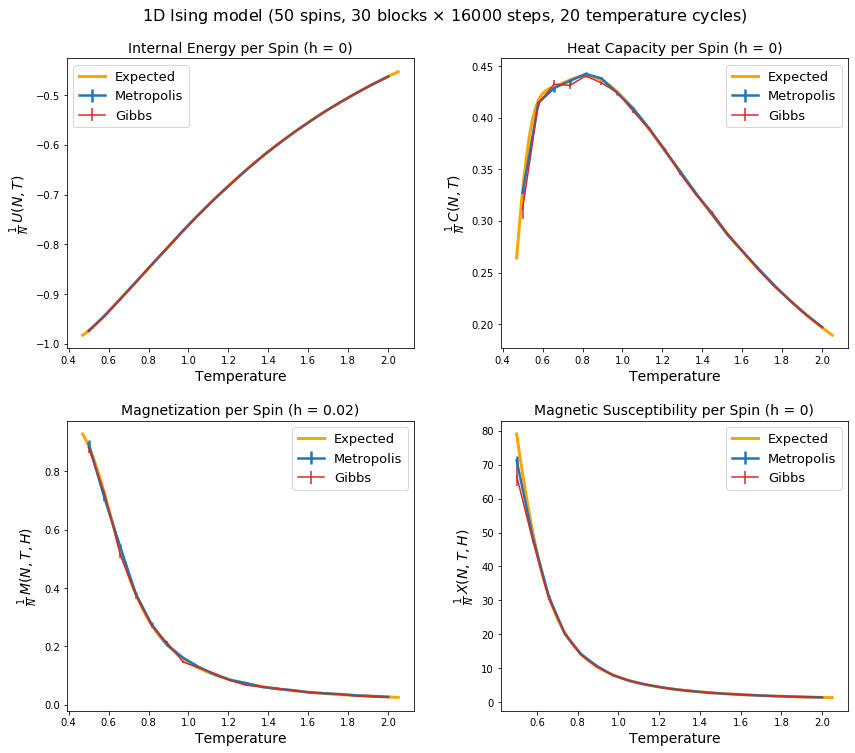

In [2]:
# Metropolis and Gibbs sampling
Nobs = 4
Nspin, T, J, Hext = [None]*4
mean, sigma = [[] for i in range(0, Nobs)], [[] for i in range(0, Nobs)] # Measures of U, C, M, X
F = [U_f, C_f, M_f, X_f] # Expected values (Functions defined above)

titles = [r"Internal Energy per Spin (h = 0)", r"Heat Capacity per Spin (h = 0)", 
         r"Magnetization per Spin (h = 0.02)", r"Magnetic Susceptibility per Spin (h = 0)"]
y_labels = [r'$\frac{1}{N}\thinspaceU(N, T)$', r"$\frac{1}{N}\thinspaceC(N, T)$", 
            r"$\frac{1}{N}\thinspaceM(N, T, H)$", r"$\frac{1}{N}\thinspaceX(N, T, H)$"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
ax = ax.flatten()
fig.suptitle(r"1D Ising model (50 spins, 30 blocks $\times$ 16000 steps, 20 temperature cycles)", y = 0.94, fontsize=16)
fig.subplots_adjust(hspace=0.25, wspace=0.25)

for i in range(0, Nobs):
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_ylabel(y_labels[i], fontsize=14)
    ax[i].set_xlabel(f"Temperature", fontsize=14)
    
    # Read and plot Metropolis Sampling
    if (os.path.isfile("Esercizio06.1/OutputData/obs"+str(i)+"_m.out")): 
        Nspin, T, J, Hext, mean[i], sigma[i] = Read("obs"+str(i)+"_m.out")
        Min, Max = min(T), max(T)
        ax[i].errorbar(T, mean[i], yerr=sigma[i], color='tab:blue', ecolor='tab:blue', label="Metropolis", 
                       linewidth=2.5)
        
    # Read and plot Gibbs Sampling
    if (os.path.isfile("Esercizio06.1/OutputData/obs"+str(i)+"_g.out")):  
        Nspin, T, J, Hext, mean[i], sigma[i] = Read("obs"+str(i)+"_g.out")
        Min, Max = min(min(T), Min), max(max(T), Max)
        ax[i].errorbar(T, mean[i], yerr=sigma[i], color='tab:red', ecolor='tab:red', label="Gibbs")
        
    # Plot the expected values
    if (i != 3): # Used to make the expected values visible (T interval extension)
        dx_min = 0.03 
        dx_max = 0.05
    else: # Since the magnetic susceptibility increases rapidly for low T, consider a smaller extension
        dx_min = 0
        dx_max = 0.05
    exp_value = [F[i](Nspin[0], t, J[0], Hext[0]) for t in np.linspace(Min-dx_min, Max+dx_max, 100)]
    ax[i].plot(np.linspace(Min-dx_min, Max+dx_max, 100), exp_value, linewidth=3, color='Orange', label="Expected")
    ax[i].legend(prop={'size': 13})
        
plt.show()